Problem Statement:
# What features are customers identifying in the category of Grocery and Gourmet Food in Amazon through their questions, and are these questions being anwered?

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [32]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

In [33]:
# Define path for Amazon data
path = r'/Users/robertspoonmore/Desktop/Capstone datasets/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [34]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [35]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")
food_df.head()

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [36]:
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


In [37]:
# in viewing the df, look for missing values
print('shape: ',food.shape)
food.isna().sum()

shape:  (19538, 3)


asin        0
question    0
answer      0
dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


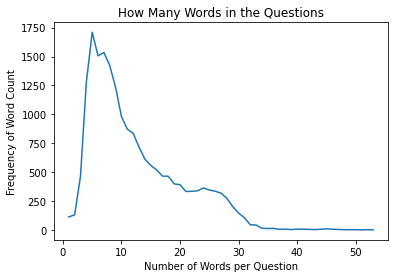

In [38]:
# Look at the word count of all the questions
food['words in question'] = food['question'].str.split().str.len()
word_count = food['words in question'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Question')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Questions')
plt.show()

In [39]:
# remove rows for questions that have only 1, 2, or 3 words
food = food[food['words in question']>3]
print("shape :",food.shape)
print("min words per question: ",food['words in question'].min())
food.head()

shape : (18827, 4)
min words per question:  4


,asin,question,answer,words in question
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20


In [40]:
#df[df['column name'].isna()]
na = food_df[food_df['answerTime']=='NaT']
print(na.count())

questionType    0
asin            0
answerTime      0
unixTime        0
question        0
answer          0
answerType      0
dtype: int64


# Preparing the question text data

In [41]:
# Import necessary modules
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Tokenization, Normalise, Remove Stop Words

In [57]:
# method to tokenize all questions, make new columm
# strip out non-alphanumeric words (remove punctuation), remove stop words
# return update column entry

def id_tokens(text):
    # Tokenise
    tokens = word.tokenize(text)
    # Retain alphabetic words: alpha_only
    alpha_only = [t for t in tokens if t.isalpha()]
    # Lowercase
    lower_tokens = [t.lower() for t in alpha_only]
    # Remove stopwords
    no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
    return no_stops

In [69]:
# Create bag of words and look at most common
all_words = []
for row in food['question']:
    words_in_row = id_tokens(row)
    for word in words_in_row:
        all_words.append(word)
food_bow = Counter(all_words)
print("Number of words found: ",len(food_bow))
print(food_bow.most_common(15))

Number of words found:  8458
[('use', 1799), ('product', 1720), ('make', 1410), ('many', 1370), ('date', 1135), ('thank', 1077), ('free', 1061), ('say', 950), ('bag', 887), ('like', 876), ('one', 825), ('ingredients', 767), ('expiration', 765), ('get', 738), ('would', 738)]


# Apply Named Entity Recognition

In [71]:
import nltk
nltk.download('averaged_perceptron_tagger')
tagged_words = nltk.pos_tag(all_words)
tagged_words[:15]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('heat', 'NN'),
 ('compare', 'NN'),
 ('yellow', 'JJ'),
 ('red', 'JJ'),
 ('curry', 'NN'),
 ('msg', 'NN'),
 ('ingredients', 'NNS'),
 ('exactly', 'RB'),
 ('product', 'NN'),
 ('thank', 'NN'),
 ('important', 'JJ'),
 ('expiraci', 'NN'),
 ('oacute', 'NN'),
 ('n', 'NN'),
 ('date', 'NN')]